# Direct surface image

To resolve the contact line dynamics, we directly image the thin liquid film next to a beet slice. Note that imaging a very thin film ($\lt 0.2$ mm) directly is challenging. Here we focus on liquid films at the thicker end (0.5-1.0 mm). A typical image is shown below.

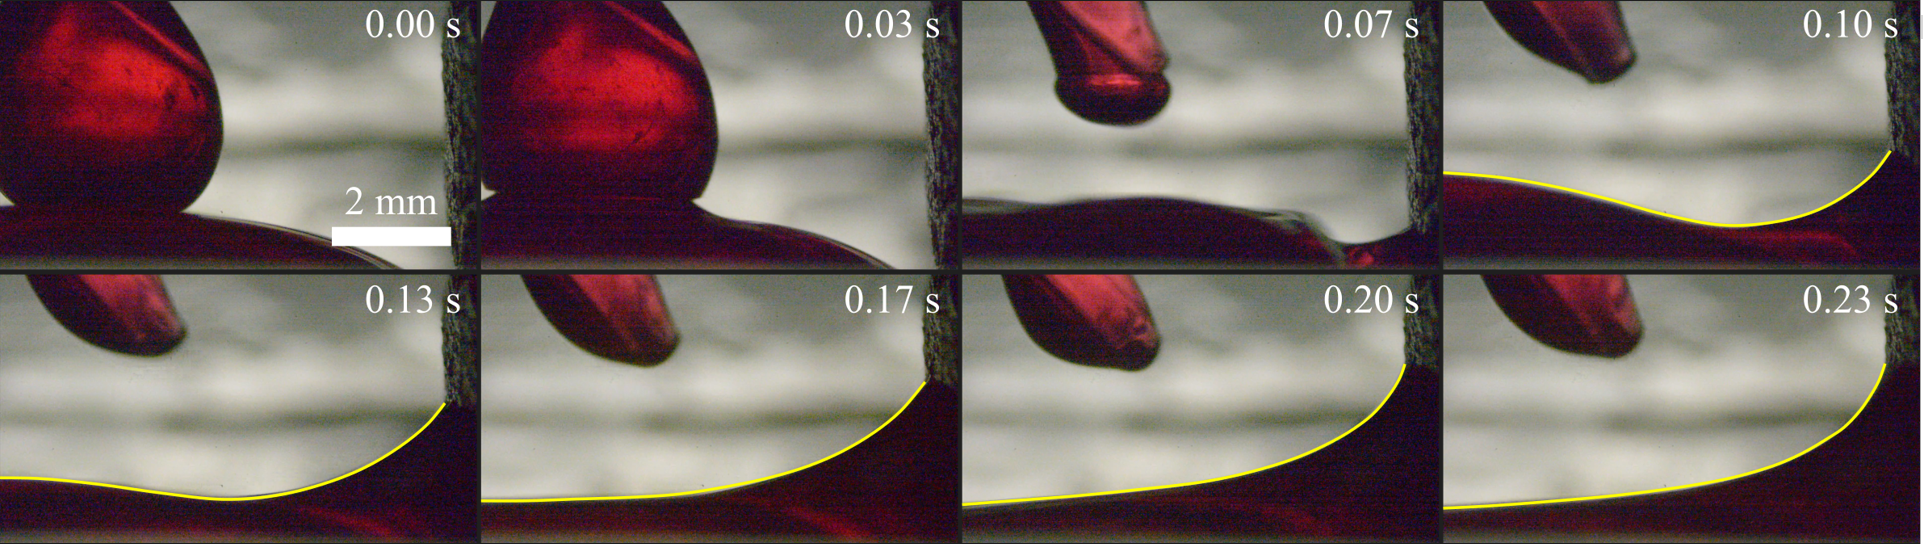

In this notebook, I develope code to detect the surface. 

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.signal import medfilt
from myimagelib.myImageLib import readdata
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

First, we detect the highest gradient in each vertical line of the image. We smoothed and cropped the image for best detection quality.

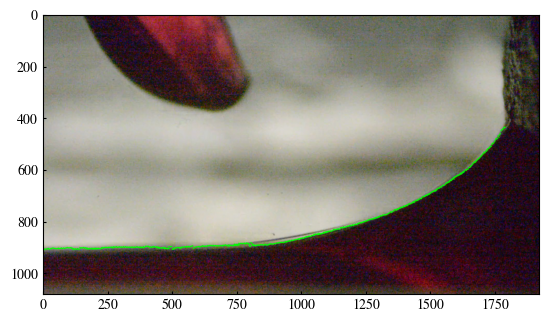

In [44]:
folder = r"F:\WPM\10232024\output_images"

# Load the image
image = cv2.imread(os.path.join(folder, "0005.jpg"))

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

h, w = gray.shape

# crop the lower image
x1, x2 = 0, 1790
y1, y2 = 400, h
crop = gray[y1:y2, x1:x2]

# Apply Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(crop, (55, 55), 0)

# Compute the vertical gradient using Sobel operator
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

# Initialize an array to store the peak positions
peaks = []

# Iterate over each column to find the peak gradient
for col in range(sobel_y.shape[1]):
    column = sobel_y[:, col]
    peak_index = np.argmax(np.abs(column)) + y1
    peaks.append(peak_index)

# Optionally, visualize the peaks on the original image
for col, peak in enumerate(peaks):
    cv2.circle(image, (col, peak), 2, (0, 255, 0), -1)

# Display the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Now, represent in x, y.

In [45]:
x = x2 - np.arange(x1, x2)
y = y2 - np.array(peaks)

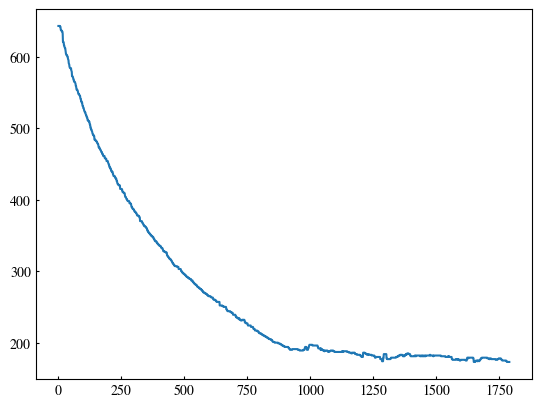

In [48]:
plt.plot(x, medfilt(y, 11))

In [49]:
def find_surface(image, crop=None, blur_kernel=55, medfilt_kernel=11):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h, w = gray.shape

    # crop the lower image
    if crop is not None:
        crop = gray
    else:
        x1, x2, y1, y2 = crop
        crop = gray[y1:y2, x1:x2]

    # Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(crop, (blur_kernel, blur_kernel), 0)

    # Compute the vertical gradient using Sobel operator
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Initialize an array to store the peak positions
    peaks = []

    # Iterate over each column to find the peak gradient
    for col in range(sobel_y.shape[1]):
        column = sobel_y[:, col]
        peak_index = np.argmax(np.abs(column)) + y1
        peaks.append(peak_index)

    x = x2 - np.arange(x1, x2)
    y = y2 - np.array(peaks)

    return x, medfilt(y, medfilt_kernel)

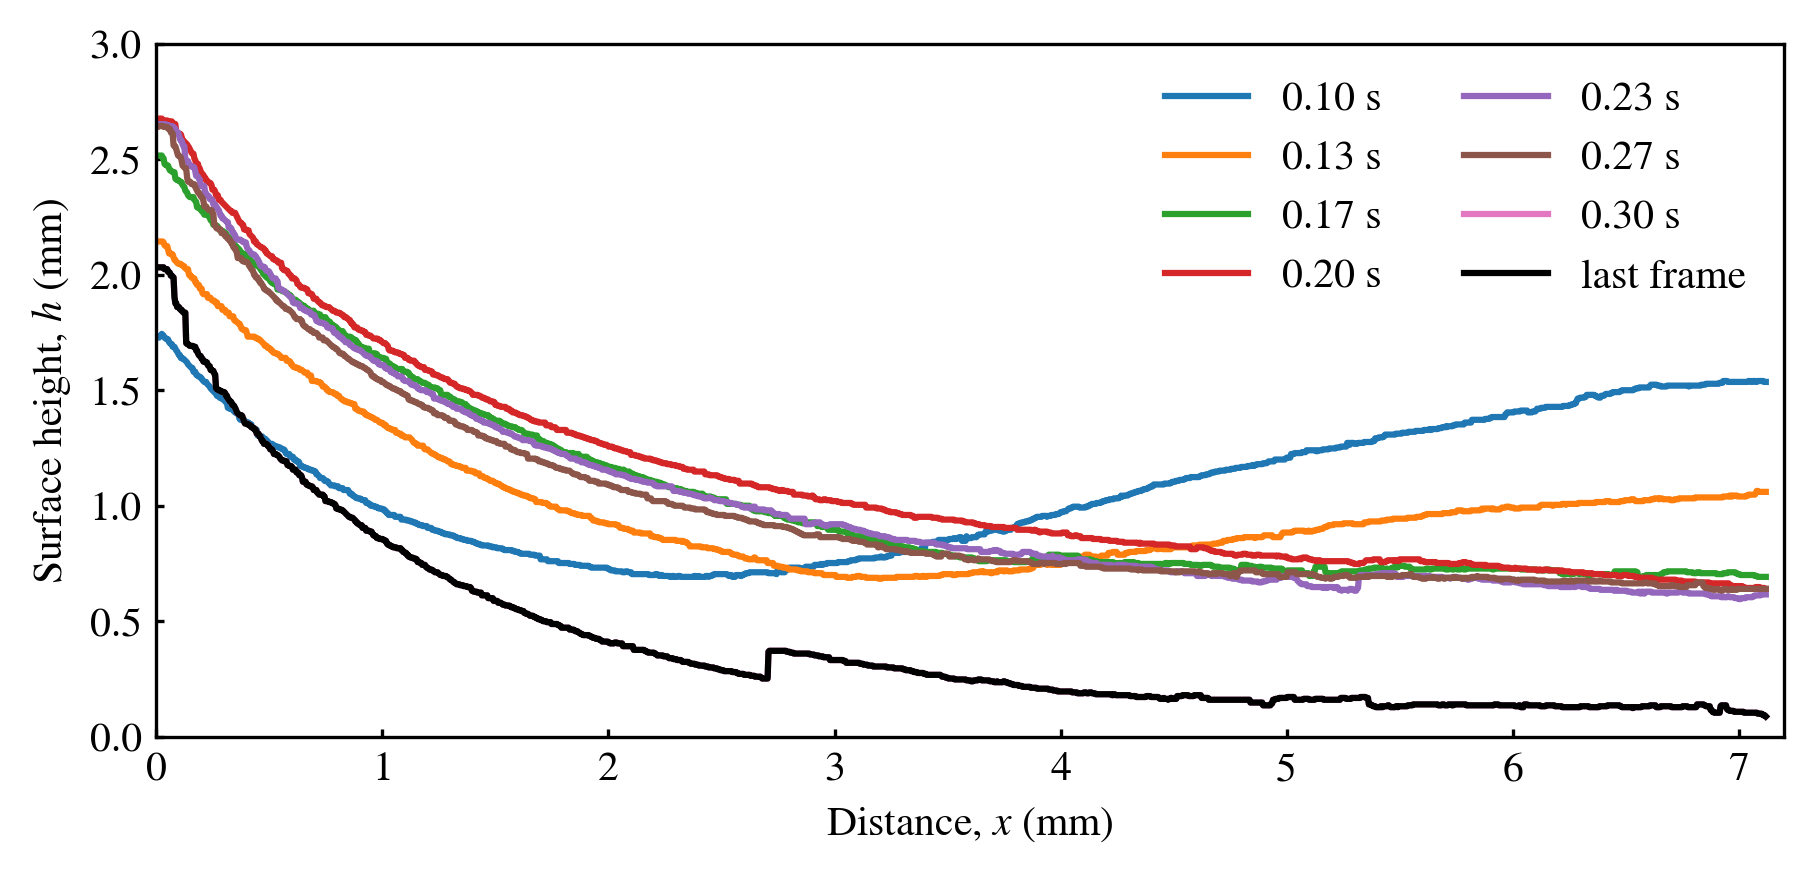

In [88]:
folder = r"F:\WPM\10232024\output_images"
l = readdata(folder, "jpg")
fps = 30
mpp = 0.004
t = np.arange(len(l)) * 1 / fps
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)
thickness = []
for num, i in l[3:].iterrows():
    image = cv2.imread(i.Dir)
    h, w = image.shape[:2]
    x, y = find_surface(image, crop=[0, 1780, 400, h])
    plt.plot(x*mpp, y*mpp, label=f"{t[num]:.2f} s")
    thickness.append(y.mean()*mpp)
plt.xlabel("Distance, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")

# plt.axis("equal")
plt.xlim([0, 7.2])
plt.ylim([0, 3])

# last frame
image = cv2.imread(os.path.join(folder, "3932.jpg"))
h, w = image.shape[:2]
x, y = find_surface(image, crop=[0, 1780, 400, h])
plt.plot(x*mpp, y*mpp, color="black", label="last frame")
thickness.append(y.mean()*mpp)

plt.legend(ncol=2, frameon=False)

In [85]:
2*np.pi*10*.042*np.cos(30/180*np.pi)

2.2853871989351147

In [94]:
theta = 60/180*np.pi
theta_s = 30/180*np.pi
42e-3*1e-7/(1e-2) * theta * (theta**2-theta_s**2)

3.6173989460349784e-07

In [95]:
0.02 * 0.01 / 42e-3 / (theta * (theta**2-theta_s**2))

0.00552883447426277